# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
cts = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']

In [4]:
# Pick the celltype for the celltype-specific training
ct = cts[3]; ct

'U2OS'

In [5]:
xb = np.load('pred/feats_train_'+ct+'.npy')
yb = np.load('pred/targs_train_'+ct+'.npy')
xq = np.load('pred/feats_valid_'+ct+'.npy')
yq = np.load('pred/targs_valid_'+ct+'.npy')

In [6]:
xb.shape # nb-by-d

(13200, 512)

In [7]:
xq.shape # nq-by-d (query vectors)

(2216, 512)

In [8]:
yb.shape, yq.shape

((13200,), (2216,))

In [9]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 459)

In [10]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [11]:
xb.max()

72.79405

In [12]:
faiss.normalize_L2(xb)

In [13]:
xb.max()

0.4194097

In [14]:
index.train(xb)

In [15]:
index.add_with_ids(xb, yb)

In [16]:
print(index.is_trained)
print(index.ntotal)

True
13200


## Train dataset

In [17]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[1028 1028 1028 1028 1028]
 [ 398  398  398  398  398]
 [ 133  133  133  133  133]
 [ 578  578  578  578  578]
 [ 679  679  679  679  679]]
[[1028]
 [ 398]
 [ 133]
 [ 578]
 [ 679]]
[[1.         0.98217463 0.9770446  0.97454995 0.97074443]
 [1.         0.99872476 0.99805546 0.997216   0.9969194 ]
 [0.99999976 0.99645114 0.99608606 0.9901214  0.98855424]
 [0.99999976 0.99706894 0.9961861  0.9940156  0.9933481 ]
 [0.99999994 0.99614733 0.99518716 0.9949318  0.9928191 ]]


In [18]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [19]:
I_train[:,0].shape, yb.shape

((13200,), (13200,))

In [20]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [21]:
I_train[:10,0], yb[:10]

(array([1028,  398,  133,  578,  679,  840,  818,  973,  443,  824]),
 array([1028,  398,  133,  578,  679,  840,  818,  973,  443,  824]))

In [22]:
I_train[-10:,0], yb[-10:]

(array([166, 688, 846, 344, 649,  92, 775, 799,  94, 722]),
 array([166, 688, 846, 344, 649,  92, 775, 799,  94, 722]))

### Train confusion matrix

In [23]:
#cm = confusion_matrix(I_train[:,0], yb)

In [24]:
#fig, ax = plt.subplots(figsize=(15,15))
#ax.matshow(cm, cmap='hot')

## Valid dataset

In [25]:
xq.max()

68.24033

In [26]:
faiss.normalize_L2(xq)

In [27]:
xq.max()

0.4462789

In [28]:
D_valid, I_valid = index.search(xq, k) # actual search

In [29]:
xq.shape, yq.shape

((2216, 512), (2216,))

In [30]:
I_valid.shape, D_valid.shape

((2216, 5), (2216, 5))

In [31]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[ 308  308  308  308  308]
 [1100 1100 1100 1100 1100]
 [ 500  500  500  881  500]
 [ 745  745  745  745  745]
 [ 345  345  497  345  345]]
[[308]
 [921]
 [673]
 [745]
 [400]]
[[0.8327124  0.8253497  0.8189806  0.8165945  0.813556  ]
 [0.6187248  0.6076201  0.60127527 0.59605634 0.59394646]
 [0.63686556 0.6343826  0.62511325 0.59306276 0.58831084]
 [0.8521872  0.838351   0.8260368  0.8195927  0.8115262 ]
 [0.46394655 0.4563948  0.4555416  0.4551882  0.4546258 ]]


In [32]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[728 728 728 728 728]
 [202 202 202 202 202]
 [824 824 824 824 824]
 [226 226 226 226 226]
 [509 509 509 509 509]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.6361375  0.6357105  0.6125775  0.61190104 0.6029438 ]
 [0.7620324  0.72024053 0.71287614 0.706797   0.70656455]
 [0.8660537  0.85642487 0.84943926 0.8483776  0.84743416]
 [0.5026909  0.50072503 0.49939328 0.49384394 0.48265857]
 [0.8606719  0.83790636 0.83435917 0.833393   0.83293164]]


In [33]:
np.save('pred/preds_valid_'+ct+'.npy', I_valid)

### Valid accuracy

In [34]:
I_valid[:,0]

array([ 308, 1100,  500, ...,  824,  226,  509])

In [35]:
yq

array([308, 921, 673, ..., 824, 328, 509])

In [36]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

1193

In [37]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.5383574007220217

In [38]:
valid_correct = np.equal(I_valid[:,0], yq)

In [39]:
valid_correct

array([ True, False, False, ...,  True, False,  True])

In [40]:
np.save('pred/preds_valid_correct_'+ct+'.npy', valid_correct)

### Valid confusion matrix

In [41]:
cm = confusion_matrix(I_valid[:,0], yq)

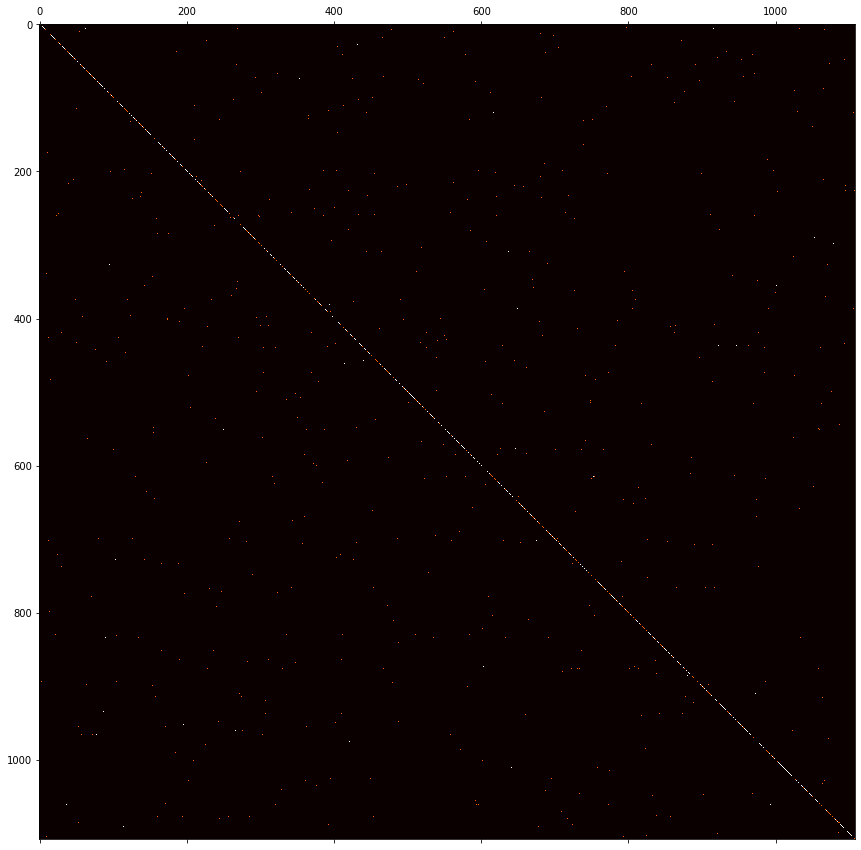

In [42]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

9690

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

5786

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.6261307831481003

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [43]:
xq_test = np.load('pred/feats_test_'+ct+'.npy')

In [44]:
xq_test.max()

49.54091

In [45]:
faiss.normalize_L2(xq_test)

In [46]:
xq_test.max()

0.39387143

In [47]:
D_test, I_test = index.search(xq_test, k) # actual search

In [48]:
xq_test.shape, I_test.shape, D_test.shape

((4410, 512), (4410, 5), (4410, 5))

In [49]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[ 735  735  735  735  735]
 [ 932  932  932  932  932]
 [ 499  499  499  499  499]
 [ 781  781  781  781  781]
 [ 766 1077 1077 1077  766]]
[[0.67048806 0.6641971  0.63414145 0.6337109  0.6313324 ]
 [0.6515162  0.6339488  0.6289718  0.6246098  0.62076247]
 [0.52397805 0.5187348  0.50463426 0.4643564  0.4640071 ]
 [0.68190545 0.6479763  0.6379318  0.6361987  0.62924767]
 [0.6333574  0.62329495 0.61608326 0.6132208  0.6108242 ]]


In [50]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[858 858 858 858 858]
 [557 557 557 557 557]
 [197 197 197 858 197]
 [926 926 926 926 926]
 [858 858 858 858 858]]
[[0.61507416 0.611241   0.6078439  0.6058894  0.60177195]
 [0.5951091  0.58896184 0.5883736  0.58013225 0.5798498 ]
 [0.5012562  0.48757213 0.48748472 0.485509   0.48414662]
 [0.68628484 0.68329716 0.68089974 0.6732561  0.66949034]
 [0.6150963  0.6117537  0.6085631  0.6079652  0.6054895 ]]


In [51]:
I_test[2]

array([499, 499, 499, 499, 499])

In [52]:
np.unique(I_test[2], return_counts=True)

(array([499]), array([5]))

In [53]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [54]:
np.save('pred/preds_test_'+ct+'.npy', preds_test)
np.save('pred/dist_test_'+ct+'.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)